### Freqeuncy Filtering


### Objectves
<ol>
<li> To avoid ringing effects from block filtering. - Gibbs Phenomena
<li> Smooth filtering
<li> Add randwom noise to avoid low values. 
<li> QC

In [48]:
import random
import os
import sys
import warnings
import datetime

from tqdm import tqdm

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import numpy.matlib
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

import scipy
from scipy.signal import butter, filtfilt
from scipy.stats import norm
import scipy.io


import segyio

from skimage.metrics import structural_similarity as ssim
# from skimage.measure import compare_ssim 
from skimage.metrics import peak_signal_noise_ratio as psnr

from sklearn.preprocessing import StandardScaler

In [49]:
## Block fitering - causes Ringing
def myStrongFilter(data,flp,fhi,delt):
    #data - input time series
    #flp - lowpass corner freq of filter
    #fhi - highpass corner freq
    #delt - sampling interval of the data
    
    flp = flp
    fhi = fhi
    
    Fs = 1/delt
    Nyq = Nyq = Fs/2
    
    Data_Freq = np.fft.fft(data)
    Filter = np.ones(Data_Freq.shape)
    Filter[:,int(np.ceil((flp/Nyq)*Data_Freq.shape[0])):int(np.ceil((fhi/Nyq)*Data_Freq.shape[0]))] = 0
    Filter[:,-int(np.ceil((fhi/Nyq)*Data_Freq.shape[0])):-int(np.ceil((flp/Nyq)*Data_Freq.shape[0]))] = 0

    Data_Freq_Filt = Data_Freq*Filter
    
    return np.real(ifft(Data_Freq_Filt))

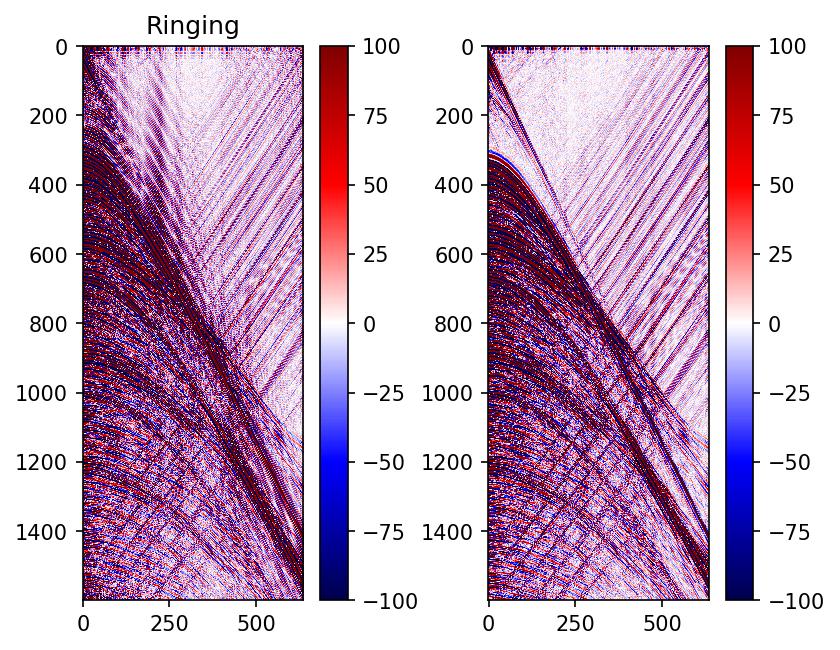

In [50]:
path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Github/Neural Network/' 
filename = 'IRP1909132tlaa.P_s1_c5_LC.sgy'

with segyio.open(path + filename, ignore_geometry=True) as f:

    
    gather = f.trace.raw[:][0:636,0:1600]
    gather_filt = myStrongFilter(gather,20,25,0.004)
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow((gather_filt).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.xlabel('Traces')
plt.ylabel('Time')
plt.title('Block Filtered')
plt.subplot(1,2,2)
plt.imshow((gather).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.xlabel('Traces')
plt.ylabel('Time')
plt.title('Original')

        

In [51]:
import scipy.signal as sc
from scipy.signal import butter, filtfilt

def filter_frequency(signal,f_low,f_high,fs):
    """
    Apply a Butterworth bandstop filter to a signal to remove frequencies in the range of 30 to 50 Hz.

    Parameters:
    signal (numpy array): Input signal to be filtered.
    fs (float): Sampling frequency of the input signal.

    Returns:
    filtered_signal (numpy array): Filtered signal with frequencies in the range of 30 to 50 Hz removed.
    """
    # Define the filter parameters
    f_stop1 = f_low  # Hz
    f_stop2 = f_high # Hz
    fs_normalized = fs  # Hz (Nyquist frequency)
    order = 4

    # Compute the filter coefficients
    b, a = sc.butter(order, [f_stop1 / fs_normalized, f_stop2 / fs_normalized], btype='bandstop')

    # Apply the filter to the input signal
    filtered_signal = sc.filtfilt(b, a, signal)

    return filtered_signal

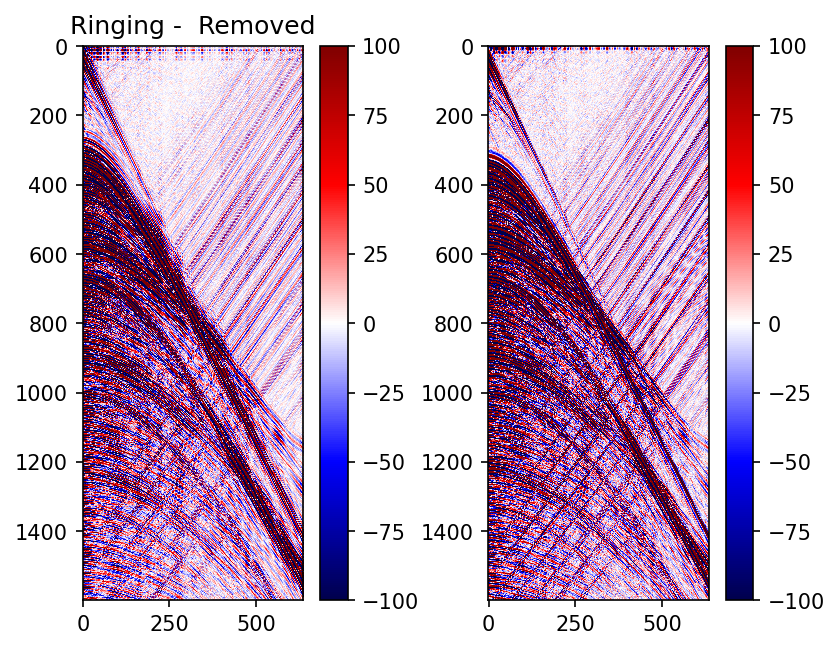

In [52]:
path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Github/Neural Network/' 
filename = 'IRP1909132tlaa.P_s1_c5_LC.sgy'
'''path = 'C:/Users/Ssach/OneDrive - Delft University of Technology/AGP/Thesis/Github/Sparse Solver/'  
filename = 'NoSI.segy' '''

with segyio.open(path + filename, ignore_geometry=True) as f:

    
    gather = f.trace.raw[:][0:636,0:1600]
    gather_filt = filter_frequency(gather,30,50,250)
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow((gather_filt).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.title('Ringing -  Removed')
plt.subplot(1,2,2)
plt.imshow((gather).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()

### QC

Text(0.5, 1.0, 'Difference')

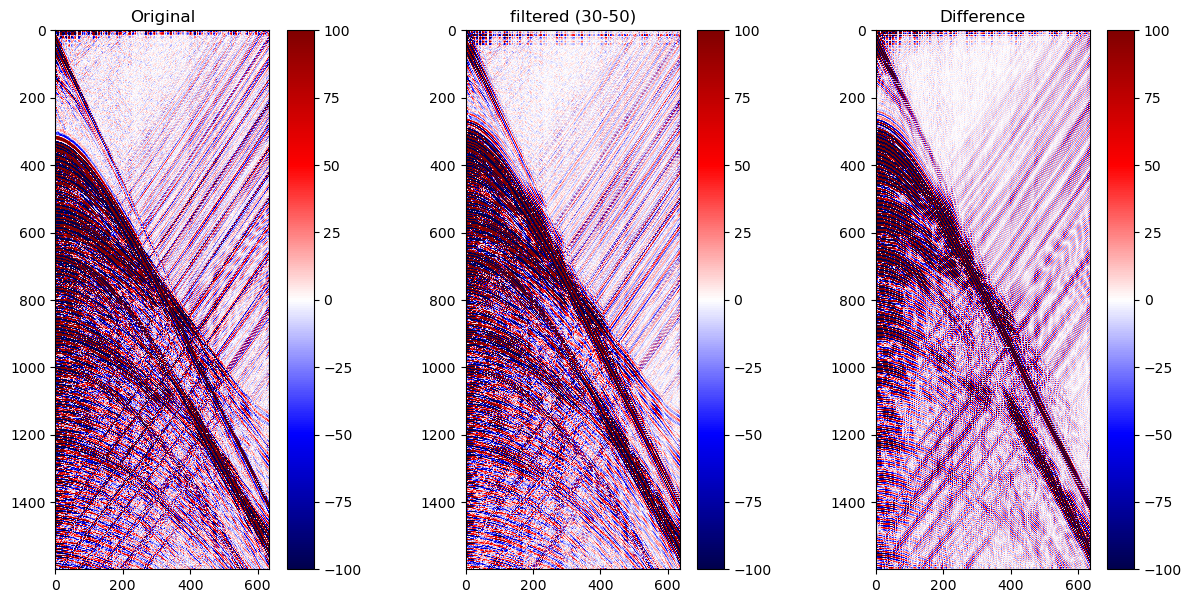

In [53]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow((gather).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow((gather_filt).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.title('filtered (30-50)')
plt.subplot(1,3,3)
plt.imshow((gather-gather_filt).T,cmap='seismic',vmax=100,vmin=-100)
plt.colorbar()
plt.title('Difference')


Text(0.5, 1.0, 'Difference')

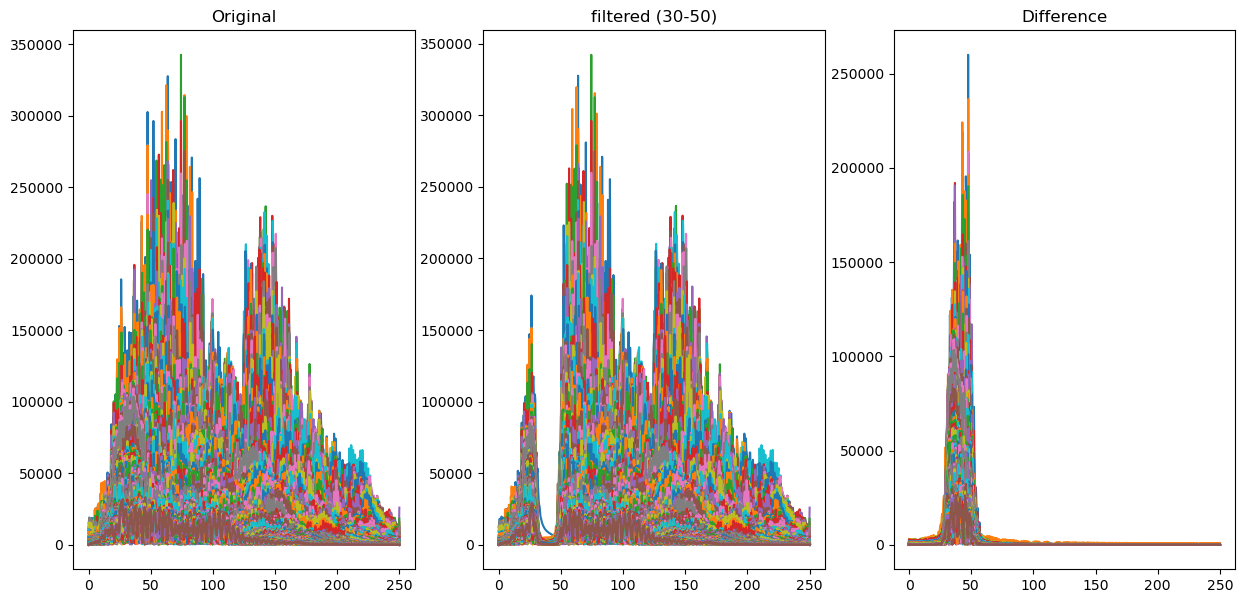

In [74]:
freq = np.linspace(0,250,801)

gather_fft = np.abs(np.fft.rfft(gather))
gather_filt_fft = np.abs(np.fft.rfft(gather_filt))

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.plot(freq,gather_fft.T)
plt.title('Original')
plt.subplot(1,3,2)
plt.plot(freq,gather_filt_fft.T)
plt.title('filtered (30-50)')
plt.subplot(1,3,3)
plt.plot(freq,np.abs(gather_fft-gather_filt_fft).T)
plt.title('Difference')

Text(0.5, 1.0, 'Difference')

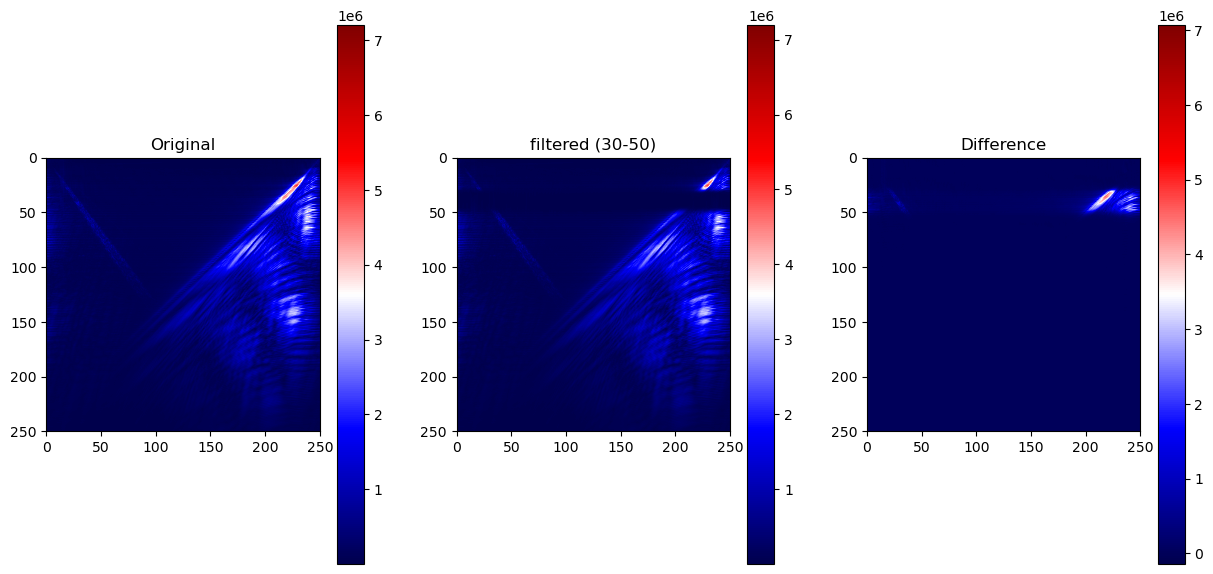

In [75]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(np.abs(np.fft.rfft2(gather)).T,cmap='seismic',extent=(0,250,250,0))
plt.colorbar()
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(np.abs(np.fft.rfft2(gather_filt)).T,cmap='seismic',extent=(0,250,250,0))
plt.colorbar()
plt.title('filtered (30-50)')
plt.subplot(1,3,3)
plt.imshow((np.abs(np.fft.rfft2(gather)) - np.abs(np.fft.rfft2(gather_filt))).T,cmap='seismic',extent=(0,250,250,0))
plt.colorbar()
plt.title('Difference')